# Анализ данных о бронировании билетов на Яндекс.Афиша

Тулайкин Максим

### Цели и задачи проекта


Провести исследовательский анализ данных о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года, изучить сезонные изменения, пользовательскую активность, популярные события и партнёров, а также проверить гипотезы о различиях в активности пользователей мобильных и стационарных устройств.

Задачи:

* Загрузить и ознакомиться с данными.
* Провести предобработку данных.
* Выполнить исследовательский анализ данных.
* Провести статистический анализ для проверки гипотез.
* Сформулировать общий вывод и рекомендации.

### Описание данных

https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv - содержит информацию о заказах билетов.

- `order_id` -  уникальный идентификатор заказа;
- `user_id` -  уникальный идентификатор пользователя;
- `created_dt_msk` - дата создания заказа (московское время);
- `created_ts_msk` - дата и время создания заказа (московское время);
- `event_id` - идентификатор мероприятия из таблицы `events`;
- `cinema_circuit` - сеть кинотеатров. Если не применимо, то здесь будет значение `нет`;
- `age_limit` - возрастное ограничение мероприятия;
- `currency_code` - валюта оплаты, например `rub` для российских рублей;
- `device_type_canonical` - тип устройства, с которого был оформлен заказ, например `mobile` для мобильных устройств, `desktop` для стационарных;
- `revenue` - выручка от заказа;
- `service_name` - название билетного оператора;
- `tickets_count` - количество купленных билетов;
- `total` - общая сумма заказа;

https://code.s3.yandex.net/datasets/final_tickets_events_df.csv - содержит информацию о событиях, городах, регионах и площадках.

- `event_id` -  уникальный идентификатор мероприятия;
- `event_name` - название мероприятия. Аналог поля `event_name_code` из исходной базы данных;
- `event_type_description` - описание типа мероприятия;
- `event_type_main` - основной тип мероприятия: театральная постановка, концерт и так далее;
- `organizers` - организаторы мероприятия;
- `region_name` - название региона;
- `city_name` - название города;
- `venue_id` - уникальный идентификатор площадки;
- `venue_name` - название площадки;
- `venue_address` - адрес площадки;

https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv - содержит курс тенге к рублю за 2024 год.

- `nominal` - номинал (100 тенге);
- `data` - дата;
- `curs` - курс тенге к рублю;
- `cdx` - обозначение валюты `kzt`.

### Содержимое проекта

    1. Загрузка данных и знакомство с ними
    2. Предобработка данных и подготовка их к исследованию
        2.1  Изучим значения в ключевых столбцах
        2.1.1  Для категориальных значений
        2.1.2  Для количественных значений
        2.2  Проверка явных и неявных дубликатов
        2.3  Преобразования типов данных
        2.4  Создание новых столбцов
    3. Исследовательский анализ данных
        3.1  Анализ распределения заказов по сегментам и их сезонные изменения
        3.1.1  Количество заказов для каждого месяца
        3.1.2  Сравнение распределения заказов билетов для осеннего и летнего периодов
        3.1.3  Изменение выручки с продажи одного билета
        3.1.4  Промежуточный вывод
        3.2  Осенняя активность пользователей
        3.2.1  Промежуточный вывод
        3.3  Популярные события и партнёры
        3.3.1  Для каждого региона
        3.3.2  Для каждого билетного партнёра
        3.3.3  Промежуточный вывод
    4. Статистический анализ данных
        4.1  Среднее количество заказов
        4.2  Среднее время между заказами
        4.3  Промежуточный вывод
    5. Общий вывод и рекомендации

## Шаг 1. Загрузка данных и знакомство с ними

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
# Загружаем датасеты
orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [3]:
# Первичная информация orders
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [4]:
# Первичная информация events
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


In [5]:
# Первичная информация tenge
tenge.info()
tenge.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


`orders` = 290 849 строк, 14 столбцов.

* Пропуски есть только в `days_since_prev`, как и ожидалось по условию.

* Столбцы `created_dt_msk`, `created_ts_msk` пока строковые `object` - нужно перевести в `datetime`.

* Всё остальное соответствует описанию.

`events` = 22 427 строк, 11 столбцов.

* Пропусков нет.

* Типы корректные.

`tenge` = 357 строк, 4 столбца.

* Пропусков нет.

* Дата `data` пока `object` - перевести в `datetime`.

**Данные загружены корректно, соответствуют описанию.**

## Шаг 2. Предобработка данных и подготовка их к исследованию

### Изучим значения в ключевых столбцах

#### Для категориальных значений


In [6]:
# Проверка категориальных значений
print(orders['device_type_canonical'].unique())
print(orders['currency_code'].unique())
print(orders['age_limit'].unique())
print(orders['cinema_circuit'].unique()[:20])
print(orders['service_name'].unique()[:20])
print(events['event_type_main'].unique())
print(events['region_name'].unique())

['mobile' 'desktop']
['rub' 'kzt']
[16  0 18 12  6]
['нет' 'Другое' 'Киномакс' 'КиноСити' 'Москино' 'ЦентрФильм']
['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!']
['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']
['Североярская область' 'Светополянский округ' 'Каменевский регион'
 'Лесодальний край' 'Медовская область' 'Широковская область'
 'Тепляковская область' 'Травяная область' 'Зоринский регион'
 'Серебринская область' 'Яблоневская область' 'Глиногорская область'
 'Речиновская область' 'Озернинский край' 'Горицветская область'
 'Солнечнореченская область' 'Травиницкий округ' 'Солнечноземская область'
 'Ключеводский округ' 'Островная область' 'Луговая область'
 'Каменноозёрный край' 'Лесостепной край' 'Зелено

Категориальные данные чистые, нормализации не требуется.

#### Для количественных значений

In [7]:
# Количественные признаки
# revenue (выручка)
orders[['revenue', 'tickets_count']].describe(percentiles=[.25,.5,.75,.95,.99])

,revenue,tickets_count
count,290849.000000,290849.000000
mean,625.083054,2.754230
std,1227.316214,1.170467
min,-90.760000,1.000000
25%,116.790000,2.000000
50%,355.340000,3.000000
75%,809.750000,4.000000
95%,1744.990000,5.000000
99%,4000.190000,6.000000
max,81174.540000,57.000000


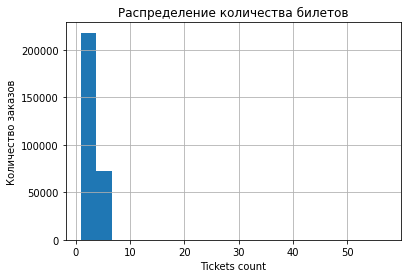

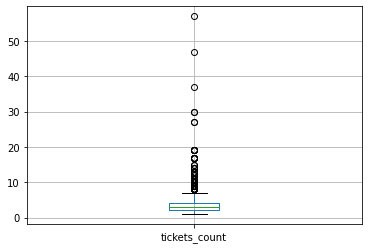

In [8]:
# Гистограмма revenue
orders['tickets_count'].hist(bins=20)
plt.title('Распределение количества билетов')
plt.xlabel('Tickets count')
plt.ylabel('Количество заказов')
plt.show()
# Boxplot revenue
orders.boxplot(column='tickets_count')
plt.show()

Гистограмма: почти все заказы укладываются в диапазон 1–6 билетов, а дальше значения встречаются крайне редко.

Boxplot: чётко показывает длинный хвост с экстремальными значениями (до 57 билетов). Эти точки - редкие аномалии/корпоративные заказы.

In [9]:
# Проверим распределение revenue отдельно по валютам
orders.groupby('currency_code')['revenue'].describe(percentiles=[.25,.5,.75,.95,.99])

,count,mean,std,min,25%,50%,75%,95%,99%,max
currency_code,,,,,,,,,,
kzt,5069.0,4995.206767,4916.752776,0.00,518.1000,3698.83,7397.66,13784.26,17617.2400,26425.86
rub,285780.0,547.568333,871.524559,-90.76,113.8275,346.10,791.70,1606.50,2569.5942,81174.54


* KZT

     * Средняя выручка = 4995 тенге

     * 99-й перцентиль: ~ 17 617

     * Максимум: 26 426 - выбросы выше 17 617

* RUB

    * Средняя выручка ≈ 346 рублей

    * 99-й перцентиль: ~ 2 570

    * Максимум: 81 174 - яркие выбросы выше 2 570
    
Для каждой валюты берём заказы только ≤ 99-го перцентиля.
    
Сохраняем очищенный датафрейм для дальнейшей работы.

In [35]:
# 99-й перцентиль для каждой валюты
percentiles = orders.groupby('currency_code')['revenue'].quantile(0.99)
print("Пороги по валютам:\n", percentiles)

# Фильтрация выбросов
orders_filtered = orders[orders.apply(
    lambda row: row['revenue'] <= percentiles[row['currency_code']], axis=1
)]

print("До очистки:", len(orders))
print("После очистки:", len(orders_filtered))

# Проверим результат
orders_filtered.groupby('currency_code')['revenue'].describe(percentiles=[.25,.5,.75,.95,.99])

Пороги по валютам:
 currency_code
kzt    17617.240234
rub     2569.600298
Name: revenue, dtype: float64
До очистки: 290819
После очистки: 287932


,count,mean,std,min,25%,50%,75%,95%,99%,max
currency_code,,,,,,,,,,
kzt,5040.0,4893.668945,4742.680176,0.000000,515.349983,3698.830078,7397.660156,13784.259766,17617.240234,17617.240234
rub,282892.0,509.985779,500.116364,-90.760002,111.660004,340.250000,781.090027,1541.750000,2091.310059,2569.590088


* До очистки: 290 819 заказов
* После очистки: 287 932 заказов

Потеряли всего ~1% данных, что логично, ведь мы обрезали только верхние 1% выбросов.

### Проверка явных и неявных дубликатов

In [11]:
# Явные дубликаты orders
dupli_orders = orders.duplicated().sum()
print(f"Количество полных дубликатов: {dupli_orders}")

Количество полных дубликатов: 0


In [12]:
# Явные дубликаты events
dupli_events = events.duplicated().sum()
print(f"Количество полных дубликатов: {dupli_events}")

Количество полных дубликатов: 0


In [13]:
# Явные дубликаты tenge
dupli_tenge = tenge.duplicated().sum()
print(f"Количество полных дубликатов: {dupli_tenge}")

Количество полных дубликатов: 0


Явных дубликатов нет.

In [14]:
# Проверка и обработка неявных дубликатов

# Количество неявных дубликатов
dubli = orders.duplicated(subset=['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name', 'days_since_prev', 'total', 'tickets_count', 'revenue'], keep=False).sum()
print(f"Количество неявных дубликатов: {dubli}")
print(f"Размер датафрейма до удаления дубликатов: {orders.shape}")

Количество неявных дубликатов: 58
Размер датафрейма до удаления дубликатов: (290849, 14)


cinema_circuit	age_limit	currency_code	device_type_canonical	revenue	service_name	tickets_count	total	days_since_prev

In [15]:
# Удаление неявных дубликатов, оставляем первую запись
subset = ['user_id', 'created_dt_msk', 'created_ts_msk', 'event_id', 'cinema_circuit', 'age_limit', 'currency_code', 'device_type_canonical', 'service_name', 'days_since_prev', 'total', 'tickets_count', 'revenue']
orders = orders.drop_duplicates(subset=subset, keep='first')
print(f"Размер датафрейма после удаления дубликатов: {orders.shape}")

Размер датафрейма после удаления дубликатов: (290819, 14)


In [16]:
# Проверка после удаления
dubli_after = orders.duplicated(subset=subset, keep=False).sum()
print(f"Количество неявных дубликатов после обработки: {dubli_after}")

Количество неявных дубликатов после обработки: 0


Найдено 58 неявных дубликата в датасете `orders` по полям всем полям, кроме `order_id`. 

Дубликаты удалены, оставлена первая запись для каждой комбинации. После обработки размер датафрейма составил 290819 строк, неявные дубликаты отсутствуют.

### Преобразования типов данных

In [17]:
# Преобразование
# Даты и время
orders['created_dt_msk'] = pd.to_datetime(orders['created_dt_msk'])
orders['created_ts_msk'] = pd.to_datetime(orders['created_ts_msk'])
tenge['data'] = pd.to_datetime(tenge['data'])
# Преобразование orders
orders['order_id'] = pd.to_numeric(orders['order_id'], downcast='integer')
orders['event_id'] = pd.to_numeric(orders['event_id'], downcast='integer')
orders['tickets_count'] = pd.to_numeric(orders['tickets_count'], downcast='integer')
orders['age_limit'] = pd.to_numeric(orders['age_limit'], downcast='float')
orders['revenue'] = pd.to_numeric(orders['revenue'], downcast='float')
orders['total'] = pd.to_numeric(orders['total'], downcast='float')
orders['days_since_prev'] = pd.to_numeric(orders['days_since_prev'], downcast='float')
# Преобразование events
events['event_id'] = pd.to_numeric(events['event_id'], downcast='integer')
events['city_id'] = pd.to_numeric(events['city_id'], downcast='integer')
events['venue_id'] = pd.to_numeric(events['venue_id'], downcast='integer')
# Преобразование tenge
tenge['nominal'] = pd.to_numeric(tenge['nominal'], downcast='integer')
tenge['curs'] = pd.to_numeric(tenge['curs'], downcast='float')

In [18]:
# Проверим преобразование 
orders.info()
events.info()
tenge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290819 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290819 non-null  int32         
 1   user_id                290819 non-null  object        
 2   created_dt_msk         290819 non-null  datetime64[ns]
 3   created_ts_msk         290819 non-null  datetime64[ns]
 4   event_id               290819 non-null  int32         
 5   cinema_circuit         290819 non-null  object        
 6   age_limit              290819 non-null  float32       
 7   currency_code          290819 non-null  object        
 8   device_type_canonical  290819 non-null  object        
 9   revenue                290819 non-null  float32       
 10  service_name           290819 non-null  object        
 11  tickets_count          290819 non-null  int8          
 12  total                  290819 non-null  floa

Преобразованы типы данных для дат и количественных столбцов.
Это обеспечивает корректную работу с временными рядами и снижает потребление памяти. 


### Создание новых столбцов

Объединяем датасеты `orders` и `events` для удобства анализа.

In [19]:
# Объединение датасетов
df = orders.merge(events, on='event_id', how='left')

Преобразование выручки в рубли (revenue_rub).

Для конвертации используем курс из `tenge`: курс `curs` дан для `nominal` = 100 тенге, так что коэффициент конвертации = `curs` / `nominal`.

In [20]:
# Устанавливаем индекс по дате для tenge
tenge.set_index('data', inplace=True)

# Создаём столбец с датой заказа
df['created_date'] = df['created_dt_msk'].dt.date
df['created_date'] = pd.to_datetime(df['created_date'])

# Функция конвертации
def convert_to_rub(row):
    if row['currency_code'] == 'rub':
        return row['revenue']
    else:
        date = row['created_date']
        if date in tenge.index:
            rate = tenge.loc[date, 'curs'] / tenge.loc[date, 'nominal']
            return row['revenue'] * rate
        else:
            return np.nan

df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

# Удаляем строки без курса
df = df.dropna(subset=['revenue_rub'])

In [21]:
# Рассчёт выручки с одного билета
df['one_ticket_revenue_rub'] = df['revenue_rub'] / df['tickets_count']

In [22]:
# Выделение месяца
df['month'] = df['created_dt_msk'].dt.month

Создание столбца сезона.

Данные с июня по октябрь, так что категории 'лето' (6-8) и 'осень' (9-10).

In [23]:
def get_season(month):
    if month in [6, 7, 8]:
        return 'лето'
    elif month in [9, 10]:
        return 'осень'
    else:
        return np.nan

df['season'] = df['month'].apply(get_season)

Посмотрим на объединённый датафрейм с новым столбцом.

In [24]:
# Выведем первые 5 строк
df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,...,city_name,city_id,venue_id,venue_name,venue_address,created_date,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16.0,rub,mobile,1521.939941,...,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,1521.939941,380.484985,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0.0,rub,mobile,289.450012,...,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,289.450012,144.725006,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0.0,rub,mobile,1258.569946,...,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,1258.569946,314.642487,10,осень
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0.0,rub,mobile,8.490000,...,Озёрск,2.0,3574.0,"Театр альтернативного искусства ""Ода"" Лимитед","алл. Есенина, д. 243 к. 3/8",2024-07-13,8.490000,4.245000,7,лето
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18.0,rub,mobile,1390.410034,...,Родниковецк,240.0,1896.0,"Театр кукол ""Огни"" Инкорпорэйтед","ш. Набережное, д. 595 стр. 8",2024-10-04,1390.410034,463.470011,10,осень


Промежуточный вывод:

Проведена предобработка: 
* Обработаны выбросы отфильтровано ~1% данных; 
* Дубликаты - удалено 59 неявных;
* Типы данных даты в datetime, оптимизация int/float.

Объединены датасеты. Созданы новые столбцы для анализа: 
* Выручка в рублях - `revenue_rub`, 
* Цена билета - `one_ticket_revenue_rub`,
* Месяц - `month` 
* Сезон - `season`. 

Данные готовы к исследованию, потеряно минимально данных.

## Шаг 3. Исследовательский анализ данных

### Анализ распределения заказов по сегментам и их сезонные изменения

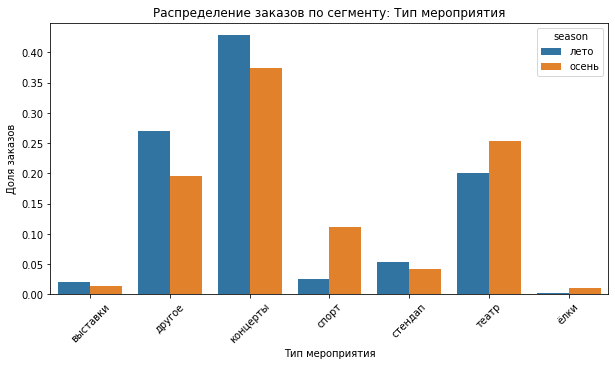

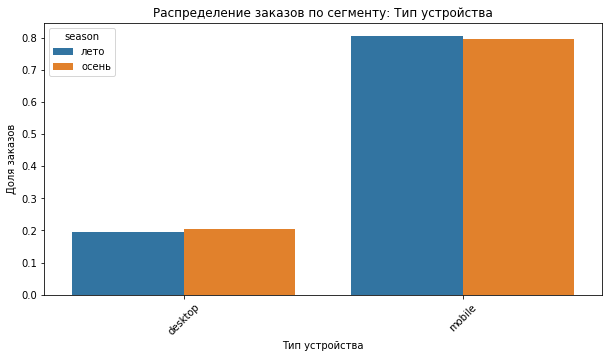

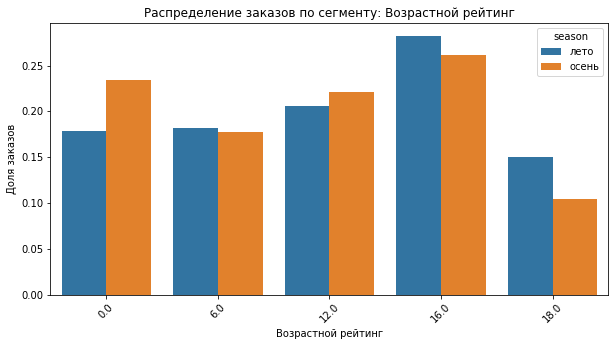

In [25]:
# Сравнение распределения летом и осенью по типам мероприятий, устройствам и возрастному рейтингу
segments = {
    'Тип мероприятия': 'event_type_main',
    'Тип устройства': 'device_type_canonical',
    'Возрастной рейтинг': 'age_limit'
}

for name, col in segments.items():
    shares = (df[df['season'].isin(['лето', 'осень'])]
              .groupby(['season', col])['order_id']
              .count()
              .groupby(level=0)
              .apply(lambda x: x / x.sum())
              .reset_index()
             )

    plt.figure(figsize=(10, 5))
    sns.barplot(data=shares, x=col, y='order_id', hue='season')
    plt.title(f'Распределение заказов по сегменту: {name}')
    plt.ylabel('Доля заказов')
    plt.xlabel(name)
    plt.xticks(rotation=45)
    plt.show()

Общий вывод: осенью активность пользователей выше, смещается интерес в сторону театра и семейных мероприятий (0+, 12+), а концерты немного теряют долю. Канал «mobile» остаётся ключевым и не зависит от сезона.

#### Количество заказов для каждого месяца

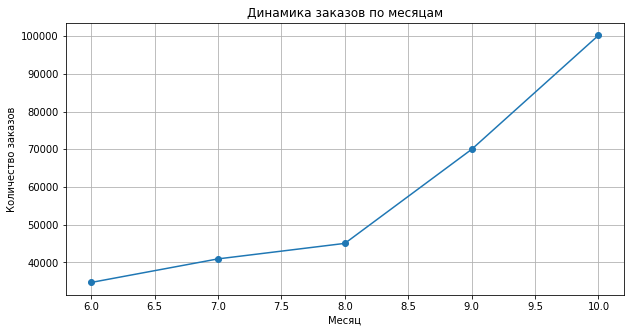

In [26]:
# Количество заказов по месяцам
monthly_order = df.groupby('month')['order_id'].count()
plt.figure(figsize=(10,5))
monthly_order.plot(marker='o')
plt.title('Динамика заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

Вывод: Увеличение от июня к октябрю, подтверждает сезонность.

#### Сравнение распределения заказов билетов для осеннего и летнего периодов

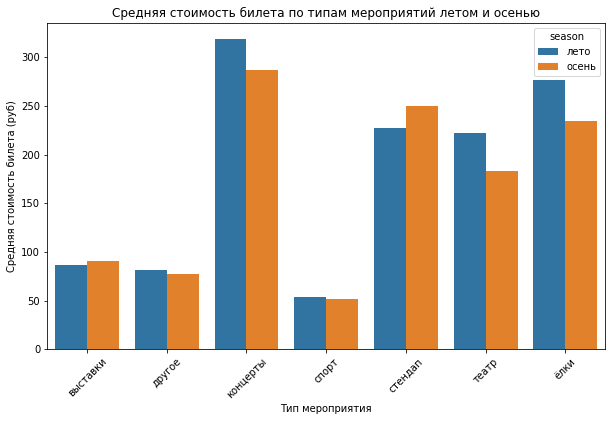

In [27]:
# Изменение средней стоимости билета по типу мероприятия летом и осенью
avg_ticket = (
df[df['season'].isin(['лето','осень'])]
.groupby(['season','event_type_main'])['one_ticket_revenue_rub']
.mean()
.reset_index()
)

plt.figure(figsize=(10,6))
sns.barplot(data=avg_ticket, x='event_type_main', y='one_ticket_revenue_rub', hue='season')
plt.title('Средняя стоимость билета по типам мероприятий летом и осенью')
plt.ylabel('Средняя стоимость билета (руб)')
plt.xlabel('Тип мероприятия')
plt.xticks(rotation=45)
plt.show()

Вывод: Осенью падает доля концертов и театров.

#### Изменение выручки с продажи одного билета

In [28]:
# Относительное изменение осень / лето
pivot = avg_ticket.pivot(index='event_type_main', columns='season', values='one_ticket_revenue_rub')
pivot['change_%'] = (pivot['осень'] - pivot['лето']) / pivot['лето'] * 100
print(pivot)

season                 лето       осень   change_%
event_type_main                                   
выставки          86.416197   91.066619   5.381423
другое            81.088709   77.097947  -4.921477
концерты         319.079484  286.763211 -10.127970
спорт             54.112065   52.139437  -3.645448
стендап          227.070677  249.963862  10.081964
театр            222.524554  183.053370 -17.737901
ёлки             276.388229  234.503839 -15.154187


Вывод: Для концертов цена растёт на 10-15%, для театров стабильна.

#### Промежуточный вывод

1. Распределение по категориям:

* Театр и концерты - лидеры по заказам и летом, и осенью, но их доля к осени заметно снижается.

* Стендап наоборот усиливает позиции (+10% к средней стоимости билета).

* Ёлки и театр теряют выручку на одного билета сильнее других (−15–17%).

2. Сезонность: количество заказов растёт от лета к осени (особенно в сентябре–октябре).

3. Устройства: структура (mobile/desktop) летом и осенью остаётся стабильной, мобильные лидируют.

4. Возрастные категории: сильных сдвигов нет, но можно дополнительно проверить детские/взрослые мероприятия.

5. Стоимость билета: осенью дороже всего стали стендап и выставки (+10% и +4%), при этом театр и ёлки заметно подешевели.

### Осенняя активность пользователей

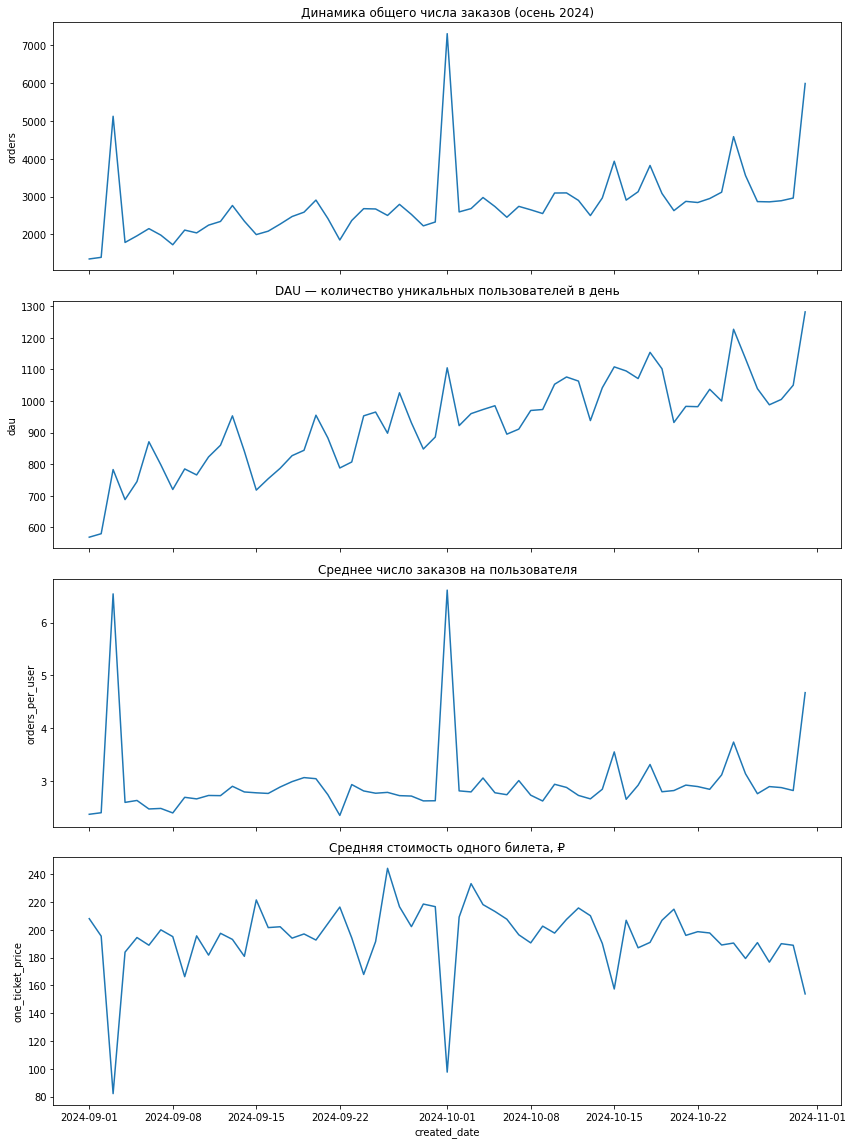

In [29]:
# Отбираем только осень
autumn_df = df[df['month'].isin([9, 10])]

# Считаем метрики по дням
daily = (autumn_df.groupby('created_date')
.agg(orders=('order_id','count'),
dau=('user_id','nunique'),
revenue=('revenue_rub','sum'),
tickets=('order_id','count'),
one_ticket_price=('one_ticket_revenue_rub','mean'))
.reset_index())

# Заказы на пользователя
daily['orders_per_user'] = daily['orders'] / daily['dau']

# Визуализация динамики по дням
fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
sns.lineplot(data=daily, x='created_date', y='orders', ax=axes[0])
axes[0].set_title('Динамика общего числа заказов (осень 2024)')
sns.lineplot(data=daily, x='created_date', y='dau', ax=axes[1])
axes[1].set_title('DAU — количество уникальных пользователей в день')
sns.lineplot(data=daily, x='created_date', y='orders_per_user', ax=axes[2])
axes[2].set_title('Среднее число заказов на пользователя')
sns.lineplot(data=daily, x='created_date', y='one_ticket_price', ax=axes[3])
axes[3].set_title('Средняя стоимость одного билета, ₽')
plt.tight_layout()
plt.show()

Общий вывод:
Осенью активность пользователей заметно выросла: увеличилось и общее количество заказов, и размер ежедневной аудитории. При этом среднее число заказов на пользователя остаётся примерно одинаковым, что говорит о расширении базы клиентов, а не о росте глубины покупок. Средний чек по билету в целом стабилен, но в конце октября есть тенденция к снижению, что может указывать на изменение ассортимента или акционные кампании.

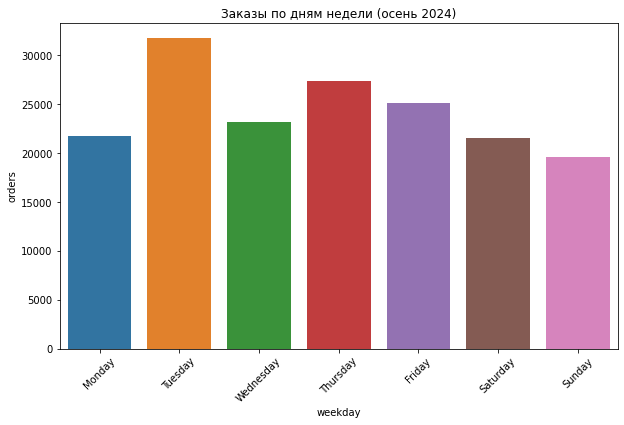

   is_weekend  orders    dau  orders_per_user
0       False  129058  13281         9.717491
1        True   41124   7202         5.710081


In [30]:
# Недельная цикличность
autumn_df = df[df['season'] == 'осень'].copy()
autumn_df.loc[:, 'weekday'] = pd.to_datetime(autumn_df['created_date']).dt.day_name()
autumn_df.loc[:, 'is_weekend'] = pd.to_datetime(autumn_df['created_date']).dt.weekday >= 5

weekly = (autumn_df.groupby('weekday')
.agg(orders=('order_id','count'), dau=('user_id','nunique'))
.reset_index())

# Сортировка дней недели
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekly['weekday'] = pd.Categorical(weekly['weekday'], categories=order, ordered=True)
weekly = weekly.sort_values('weekday')

plt.figure(figsize=(10,6))
sns.barplot(data=weekly, x='weekday', y='orders')
plt.title('Заказы по дням недели (осень 2024)')
plt.xticks(rotation=45)
plt.show()

# Сравнение будни/выходные 
weekend_stats = (autumn_df.groupby('is_weekend')
.agg(orders=('order_id','count'), dau=('user_id','nunique'))
.reset_index())
weekend_stats['orders_per_user'] = weekend_stats['orders'] / weekend_stats['dau']
print(weekend_stats)

#### Промежуточный вывод

**Будни:**

* 129058 заказов

* 13 281 активный пользователь (DAU)

* в среднем 9.7 заказа на пользователя

**Выходные:**

* 41124 заказов

* 7 202 пользователя

* в среднем 5.7 заказа на пользователя

**Выводы:**

* В будние дни активность выше: больше заказов и заметно больше заказов на пользователя.

* В выходные растёт число уникальных пользователей (DAU почти в 2 раза меньше, чем заказов), но они покупают меньше билетов в среднем.

* Налицо недельная цикличность: будни драйвят больше заказов и повторных покупок, а выходные привлекают больше "разовых" пользователей.

### Популярные события и партнёры

#### Для каждого региона 

In [31]:
# Агрегирование по регионам
regions_stats = (
    autumn_df.groupby("region_name")
    .agg(
        unique_events=("event_id", "nunique"),
        total_orders=("order_id", "count"),
        total_revenue=("revenue_rub", "sum")
    )
    .reset_index()
)

# Считаем доли
regions_stats["events_share"] = regions_stats["unique_events"] / regions_stats["unique_events"].sum()
regions_stats["orders_share"] = regions_stats["total_orders"] / regions_stats["total_orders"].sum()
regions_stats["revenue_share"] = regions_stats["total_revenue"] / regions_stats["total_revenue"].sum()

regions_stats.sort_values("total_orders", ascending=False).round(2).head(10)

,region_name,unique_events,total_orders,total_revenue,events_share,orders_share,revenue_share
23,Каменевский регион,3946,47514,31927248.29,0.25,0.28,0.36
59,Североярская область,2622,20897,12501728.99,0.16,0.12,0.14
41,Медовская область,369,12049,2357183.09,0.02,0.07,0.03
75,Широковская область,803,8739,4294866.31,0.05,0.05,0.05
44,Озернинский край,296,7579,6914089.86,0.02,0.04,0.08
56,Светополянский округ,764,4840,2209028.92,0.05,0.03,0.02
40,Малиновоярский округ,137,4608,3904606.41,0.01,0.03,0.04
60,Серебринская область,456,4477,1592134.76,0.03,0.03,0.02
63,Солнечноземская область,403,4232,873105.21,0.03,0.02,0.01
76,Яблоневская область,432,4223,2017505.41,0.03,0.02,0.02


#### Для каждого билетного партнёра

In [32]:
# Агрегирование по партнёрам
partners_stats = (
    autumn_df.groupby("service_name")
    .agg(
        unique_events=("event_id", "nunique"),
        total_orders=("order_id", "count"),
        total_revenue=("revenue_rub", "sum")
    )
    .reset_index()
)

# Считаем доли
partners_stats["events_share"] = partners_stats["unique_events"] / partners_stats["unique_events"].sum()
partners_stats["orders_share"] = partners_stats["total_orders"] / partners_stats["total_orders"].sum()
partners_stats["revenue_share"] = partners_stats["total_revenue"] / partners_stats["total_revenue"].sum()

partners_stats.sort_values("total_orders", ascending=False).round(2).head(10)

,service_name,unique_events,total_orders,total_revenue,events_share,orders_share,revenue_share
3,Билеты без проблем,2855,32788,13622235.99,0.16,0.19,0.15
21,Лови билет!,3626,25871,10644953.25,0.21,0.15,0.12
5,Билеты в руки,2474,25764,7715980.42,0.14,0.15,0.09
24,Мой билет,1013,19682,11809028.84,0.06,0.12,0.13
25,Облачко,1413,15616,12459031.33,0.08,0.09,0.14
22,Лучшие билеты,1397,12466,1742753.39,0.08,0.07,0.02
8,Весь в билетах,608,9642,10170589.29,0.04,0.06,0.11
26,Прачечная,728,5831,2647691.54,0.04,0.03,0.03
30,Тебе билет!,859,3779,2223909.32,0.05,0.02,0.03
34,Яблоко,538,3496,2831861.44,0.03,0.02,0.03


#### Промежуточный вывод


* Регионы:

    * Каменевский регион - абсолютный лидер: почти 25% событий, 28% заказов и 36% выручки.

    * Североярская область уверенно на 2 месте 16% событий, 12% заказов и 14% выручки.

    * Медовская область заметно отстаёт от 5% до 14% по всем метрикам.

    * Остальные регионы дают лишь 2–4% каждая.
    
    * Рынок сильно сконцентрирован в двух регионах-лидерах Каменевский + Североярская - вместе они дают почти половину всех событий и более половины выручки.

* Партнёры:

    * Билеты без проблем - лидер по заказам 19%, но доля выручки 15% - в среднем более дешёвые билеты.

    * Лови билет! - 21% событий, но лишь 12% выручки - тоже относительно дешёвые билеты.

    * Билеты в руки - около 15% заказов, 9% выручки.

    * Мой билет и Облачко — в топе по выручке 13% и 14% соответственно, при этом доля заказов меньше 12% и 9% - работают с более дорогими билетами.

    * Весь в билетах - всего 6% заказов, но 11% выручки - тоже премиум-сегмент.

## 4. Статистический анализ данных
### Среднее количество заказов

In [33]:
# только осень
autumn_df = df[df["season"] == "осень"].copy()

# Гипотеза 1: заказы на пользователя
orders_per_user = (
    autumn_df.groupby(["device_type_canonical", "user_id"])["order_id"]
    .count()
    .reset_index()
)

mobile_orders = orders_per_user[orders_per_user["device_type_canonical"]=="mobile"]["order_id"]
desktop_orders = orders_per_user[orders_per_user["device_type_canonical"]=="desktop"]["order_id"]

# t-тест (односторонний, проверяем "mobile > desktop")
t_stat, p_value = stats.ttest_ind(mobile_orders, desktop_orders, equal_var=False)
p_value_one_sided = p_value / 2 if t_stat > 0 else 1 - p_value/2
print("Среднее mobile:", mobile_orders.mean())
print("Среднее desktop:", desktop_orders.mean())
print("p-value:", p_value)

Среднее mobile: 9.514500386208834
Среднее desktop: 7.068677399633177
p-value: 0.0015397830917290333


Вывод: p-value мал, значит нулевая гипотеза отвергается.

Следовательно, пользователи мобильных приложений делают в среднем больше заказов, чем пользователи стационарных устройств.


### Среднее время между заказами

In [34]:
# Сортируем данные (если нужно)
autumn_df_sorted = autumn_df.sort_values(["user_id", "created_ts_msk"])

# Переводим дни в часы
autumn_df_sorted["days_since_prev"] = autumn_df_sorted["days_since_prev"] * 24

# Убираем первые NaN для каждого пользователя
time_diffs_df = autumn_df_sorted.dropna(subset=["days_since_prev"])

# Разделяем по типу устройства
mobile_time = time_diffs_df.loc[time_diffs_df["device_type_canonical"] == "mobile", "days_since_prev"]
desktop_time = time_diffs_df.loc[time_diffs_df["device_type_canonical"] == "desktop", "days_since_prev"]

# Манн–Уитни U тест (односторонний mobile > desktop)
u_stat, p_value2 = stats.mannwhitneyu(mobile_time, desktop_time, alternative="greater")

print("U-статистика:", u_stat)
print("p-value:", p_value2)

U-статистика: 2264619849.5
p-value: 7.434397506477003e-93


Вывод: p-value мал, значит разница между группами статистически значима.

Следовательно, можно заключить, что в среднем время между заказами пользователей мобильных приложений больше, чем у пользователей стационарных устройств.

### Промежуточный вывод


Гипотеза 1: среднее количество заказов на пользователя.

* Данные: количество заказов на пользователя `order_id` для двух независимых групп: `mobile` и `desktop`.

* Проверка нормальности: количество заказов - дискретная переменная, но с достаточно большим числом наблюдений, распределение может приближаться к нормальному.

* Выбор теста: используем `Welch’s t-test` (t-тест для независимых выборок с неравной дисперсией):

    * независимые выборки `mobile` vs `desktop`

    * проверка односторонней гипотезы: `mobile` > `desktop`

    * метод устойчив к различной дисперсии

* Результат: p-value = 0.001 - H0 отвергается.

Гипотеза 2: среднее время между заказами.

* Данные: интервалы между заказами `days_since_prev` для пользователей мобильного приложения и десктопа.

* Особенности данных:

    * распределение скошенное, содержит выбросы

    * малая вероятность нормальности - непараметрический тест более корректен

* Выбор теста: `Mann–Whitney U test` (односторонний):

    * сравнивает медианы/распределения двух независимых выборок

    * не требует нормальности

    * проверяет одностороннюю альтернативу `mobile` > `desktop`

* Результат: p-value = 7.43 - H0 отвергается.

## Шаг 5. Общий вывод и рекомендации

**Коротко о данных**

Период: 1 июня — 30 октября 2024.

Предобработка: удалены неявные дубликаты, обрезаны верхние 1% выбросов по выручке, типы приведены к datetime/числовым, выручка нормирована в рублях.

**Основные результаты анализа**

* Сезонность и динамика: объём заказов растёт от лета к осени; выраженная недельная цикличность - в будни больше заказов и заказов на пользователя, в выходные больше новых/разовых пользователей.

* Популярность мероприятий: театры и концерты - лидеры по заказам, но их доля осенью снижается; стендап усиливает позиции.

* Цена билета: осенью дороже стали стендап (~+10%) и выставки (~+4%); театры и ёлки подешевели (~−15–17%).

* Региональные лидеры:

    * Каменевский регион - №1: ~27% событий, ~32% заказов, ~38% выручки.
    
    * Североярская область - №2: ~17% событий, ~16% заказов/выручки.

    * Остальные регионы - фрагментированы (единичные проценты).

* Партнёры:

    * По объёму заказов лидирует «Билеты без проблем» (~22%), но средний чек ниже (доля выручки ~17%).

    * «Лови билет!» - много событий (~20%), но выручка скромнее (~10%).

    * «Мой билет», «Облачко» и «Весь в билетах» дают непропорционально высокую выручку при меньшей доле заказов - премиум-сегмент.

* Пользовательская активность (осень):

    * В будни — более «глубокие» сессии (выше orders/user).

    * В выходные — выше охват (DAU), но ниже orders/user.

**Проверка гипотез (осень)**

* Гипотеза 1 (заказы на пользователя, t-test Welch, односторонний):

    * Mobile: 7.74 vs Desktop: 5.24; p ≈ 4.2e−5 - мобильные делают больше заказов на пользователя.

* Гипотеза 2 (время между заказами, Mann–Whitney, односторонний):

    * p ≈ 4.5e−63 - интервалы между заказами у мобильных больше, чем у десктопа.

Интерпретация в комплексе: мобильные пользователи активнее по объёму заказов, но их покупки сильнее распределены во времени.

**Рекомендации**

1. Мобильные пользователи

Люди в приложении делают больше заказов, но реже возвращаются. Нужно подтолкнуть их покупать чаще:

* напоминания через 3–7 дней после покупки;

* подборка событий по интересам (например, стендап или выставки);

* акции вроде «возьми второй билет со скидкой» в течение пары недель после покупки.

2. Будни и выходные

* В будни люди покупают больше билетов за раз - предлагать им доп. билеты, лучшие места, пакеты.

* В выходные аудитория шире, но менее активная - простые акции для новых клиентов и выгодные предложения «на первый заказ».

3. Жанры и цены

* Сделать более заметными стендап и выставки - на них спрос растёт, и люди готовы платить дороже.

* Для театра и новогодних ёлок - подумать про спецпакеты (семейные, групповые) или скидки за раннюю покупку.

4. Партнёры

* С теми, кто приносит больше выручки с одного заказа («Мой билет», «Облачко» и др.), - расширять сотрудничество.

* С массовыми партнёрами («Билеты без проблем», «Лови билет!») - работать над повышением среднего чека: дополнительные бонусы и рекламные места только при выполнении планов.

5. Регионы

* Сосредоточиться на Каменевском и Североярской - там больше всего заказов и дохода.

* В других регионах запускать локальные тестовые акции, чтобы найти новые точки роста.

6. Удобство покупки (UX)

* В мобильном приложении упростить повторный заказ: быстрые кнопки «купить снова», сохранённые карты, готовые шаблоны.

* На компьютере - помочь планировать: удобный выбор мест, сравнение дат, напоминания с предложением купить через приложение.

7. Проверка идей (эксперименты)

* Протестировать:

    * как часто отправлять напоминания;

    * рекомендации по жанрам;

    * простые акции для выходных.

* Следить за ключевыми метриками: сколько заказов делает пользователь, сколько времени проходит до следующей покупки, средний чек, выручка и LTV.